### Tanpa Hyperparameter Tuning

[[[-1387. -1368. -1351. ... -1647. -1580. -1446.]
  [-1434. -1415. -1377. ... -1532. -1577. -1630.]
  [ -948. -1098. -1398. ...  -870.  -648.  -759.]
  ...
  [-1027. -1106. -1264. ...  -738.  -845. -1058.]
  [-1319. -1197. -1136. ... -1384. -1446. -1487.]
  [-1509. -1474. -1455. ... -1413. -1501. -1563.]]

 [[-1434. -1415. -1377. ... -1532. -1577. -1630.]
  [ -948. -1098. -1398. ...  -870.  -648.  -759.]
  [-1424. -1248.  -948. ... -1294. -1153.  -870.]
  ...
  [-1319. -1197. -1136. ... -1384. -1446. -1487.]
  [-1509. -1474. -1455. ... -1413. -1501. -1563.]
  [-1388. -1429. -1456. ... -1336. -1347. -1369.]]

 [[ -948. -1098. -1398. ...  -870.  -648.  -759.]
  [-1424. -1248.  -948. ... -1294. -1153.  -870.]
  [-1479. -1438. -1356. ... -1340. -1356. -1388.]
  ...
  [-1509. -1474. -1455. ... -1413. -1501. -1563.]
  [-1388. -1429. -1456. ... -1336. -1347. -1369.]
  [-1347. -1369. -1413. ... -1290. -1323. -1301.]]

 ...

 [[-1462. -1498. -1474. ... -1593. -1671. -1619.]
  [-1818. -1856. -18

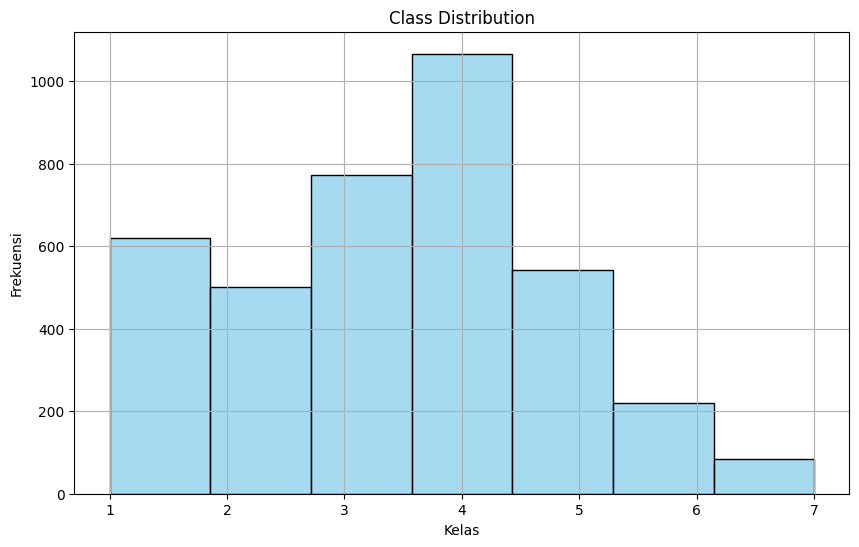

Unique values in y: [1. 2. 3. 4. 5. 6. 7.]


/tmp/ipykernel_863146/1004745020.py:89: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=build_model, input_shape=(X_train.shape[1], X_train.shape[2]), num_classes=num_classes, verbose=0)
2024-08-18 11:28:12.231581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-18 11:28:12.233726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value fo

KeyboardInterrupt: 

In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

def create_lstm_model(units=50, dropout_rate=0.2, input_shape=(None, 31), num_classes=2):
    model = Sequential()
    model.add(LSTM(units, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return model

def prepare_data(df, sequence_length, feature_columns, target_column):
    # Convert to numeric and handle comma as decimal separator
    for col in feature_columns:
        df[col] = df[col].astype(str).str.replace(',', '.').astype(float)
    
    df[target_column] = df[target_column].astype(float)
    
    X, y = [], []
    for i in range(len(df) - sequence_length):
        X.append(df[feature_columns].iloc[i:i + sequence_length].values)
        y.append(df[target_column].iloc[i + sequence_length])
    X = np.array(X)
    y = np.array(y)
    
    # Reshape X to 3D array for LSTM input [samples, time steps, features]
    X = X.reshape((X.shape[0], sequence_length, len(feature_columns)))
    
    return X, y

def plot_confusion_matrix(cm, classes, title, dataset_name):
    plt.figure(figsize=(8, 8))
    percentages = (cm.T / cm.sum(axis=1) * 100).T
    plt.imshow(percentages, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=100)
    plt.title(f'Confusion Matrix - {title} - {dataset_name}')
    plt.colorbar(label='Percentage')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, f"{cm[i, j]}\n{percentages[i, j]:.1f}%", horizontalalignment='center',
                     color='white' if percentages[i, j] > 50 else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    plt.close()

def build_model(units, dropout_rate, input_shape, num_classes):
    return create_lstm_model(units=units, dropout_rate=dropout_rate, input_shape=input_shape, num_classes=num_classes)

def modeling(Y, X, nama_model):
    # Adjust labels to start from 0
    Y = Y - 1  # Assuming labels start from 1 and need to be adjusted to start from 0

    # Stratified split
    X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
    X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42, stratify=Y_temp)

    # Ensure that X is float32 and Y is int
    X_train = X_train.astype(np.float32)
    X_val = X_val.astype(np.float32)
    X_test = X_test.astype(np.float32)
    Y_train = Y_train.astype(np.int32)
    Y_val = Y_val.astype(np.int32)
    Y_test = Y_test.astype(np.int32)

    # One-hot encoding for labels
    num_classes = len(np.unique(Y))
    Y_train = to_categorical(Y_train, num_classes=num_classes)
    Y_test = to_categorical(Y_test, num_classes=num_classes)
    Y_val = to_categorical(Y_val, num_classes=num_classes)

    # Define the Keras model
    model = KerasClassifier(build_fn=build_model, input_shape=(X_train.shape[1], X_train.shape[2]), num_classes=num_classes, verbose=0)

    # Grid search for hyperparameter tuning
    param_grid = {
        'units': [20, 50],  # Range of units to test
        'dropout_rate': [0.2, 0.3],  # Range of dropout rates to test
        'batch_size': [16, 32],  # Range of batch sizes to test
        'epochs': [5, 10]  # Range of epochs to test
    }

    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=2)  # Use fewer jobs and folds
    grid_result = grid.fit(X_train, Y_train)

    # Best model
    best_model = grid_result.best_estimator_
    print("Best parameters:", grid_result.best_params_)

    # Evaluation
    Y_val_pred_prob = best_model.predict_proba(X_val)
    Y_val_pred = np.argmax(Y_val_pred_prob, axis=1)
    Y_true = np.argmax(Y_val, axis=1)

    accuracy_val_pred = accuracy_score(Y_true, Y_val_pred)
    precision_val_pred = precision_score(Y_true, Y_val_pred, average='weighted')
    recall_val_pred = recall_score(Y_true, Y_val_pred, average='weighted')
    f1_micro_val_pred = f1_score(Y_true, Y_val_pred, average='micro')
    f1_macro_val_pred = f1_score(Y_true, Y_val_pred, average='macro')
    cm = confusion_matrix(Y_true, Y_val_pred)

    print("Accuracy:", accuracy_val_pred)
    print("Precision:", precision_val_pred)
    print("Recall:", recall_val_pred)
    print("F1 Micro:", f1_micro_val_pred)
    print("F1 Macro:", f1_macro_val_pred)
    
    # Save the evaluation results
    with open(f'evaluation_{nama_model}.txt', 'w') as f:
        f.write(f"Accuracy: {accuracy_val_pred}\n")
        f.write(f"Precision: {precision_val_pred}\n")
        f.write(f"Recall: {recall_val_pred}\n")
        f.write(f"F1 Micro: {f1_micro_val_pred}\n")
        f.write(f"F1 Macro: {f1_macro_val_pred}\n")

    plot_confusion_matrix(cm, classes=np.unique(Y_true), title=nama_model, dataset_name='Validation')

    # Save the best model
    joblib.dump(best_model, f'best_model_{nama_model}.pkl')

    return best_model

def model_utilization(file_path, sequence_length, nama_model):
    try:
        df = pd.read_csv(file_path, sep = ";")
    except pd.errors.ParserError as e:
        print(f"Error parsing the CSV file: {e}")
        return None

    # Clean data: remove rows with inconsistent columns
    df = df.dropna()  # Drop rows with any NaN values
    feature_columns = [f'VH_{i}' for i in range(0, 31)]
    target_column = 'observation'

    # Prepare data
    X, y = prepare_data(df, sequence_length, feature_columns, target_column)
    plot_class_distribution(y)

    # Debugging: Check unique values in y
    print(f"Unique values in y: {np.unique(y)}")

    # Modeling and evaluation
    best_model = modeling(y, X, nama_model)

    return best_model

def plot_class_distribution(y, title='Class Distribution'):
    plt.figure(figsize=(10, 6))
    sns.histplot(y, kde=False, bins=len(set(y)), color='skyblue', edgecolor='black')
    plt.title(title)
    plt.xlabel('Kelas')
    plt.ylabel('Frekuensi')
    plt.xticks(ticks=sorted(set(y)))
    plt.grid(True)
    plt.show()

# Menjalankan fungsi model_utilization jika dijalankan sebagai script utama
if __name__ == "__main__":
    # Contoh path file
    file_path = '../../00_Data_Input/sampel_to_explore.csv'  # Update path here
    sequence_length = 31
    nama_model = 'LSTM_Model'
    best_model = model_utilization(file_path, sequence_length, nama_model)

### GridSearchCV Hyperparameter Tuning

2024-08-20 07:58:20.259397: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-20 07:58:20.262561: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-20 07:58:20.369358: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-20 07:58:20.372154: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-20 07:58:21.670919: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

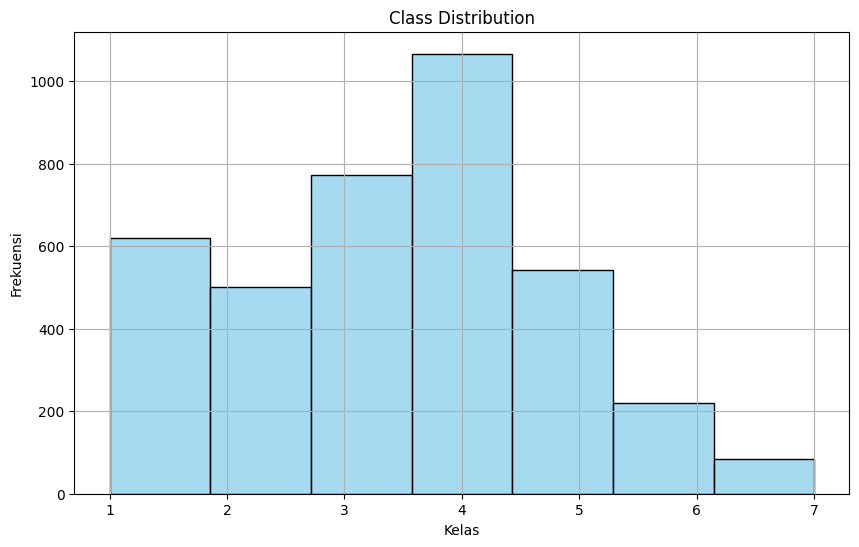

/tmp/ipykernel_1608284/3209158292.py:95: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_train = Y_train.astype(np.int)
/tmp/ipykernel_1608284/3209158292.py:96: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1

Best parameters: {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 10, 'optimizer': 'adagrad', 'units': 20}


2024-08-20 09:58:15.702197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-20 09:58:15.704181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-20 09:58:15.706227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

12/12 [==============================] - 1s 10ms/step
Validation Accuracy: 0.2789473684210526
Validation Precision: 0.07781163434903046
Validation Recall: 0.2789473684210526
Validation F1 Micro: 0.2789473684210526
Validation F1 Macro: 0.06231628453850676


/data/home/raflizal.fikrar/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


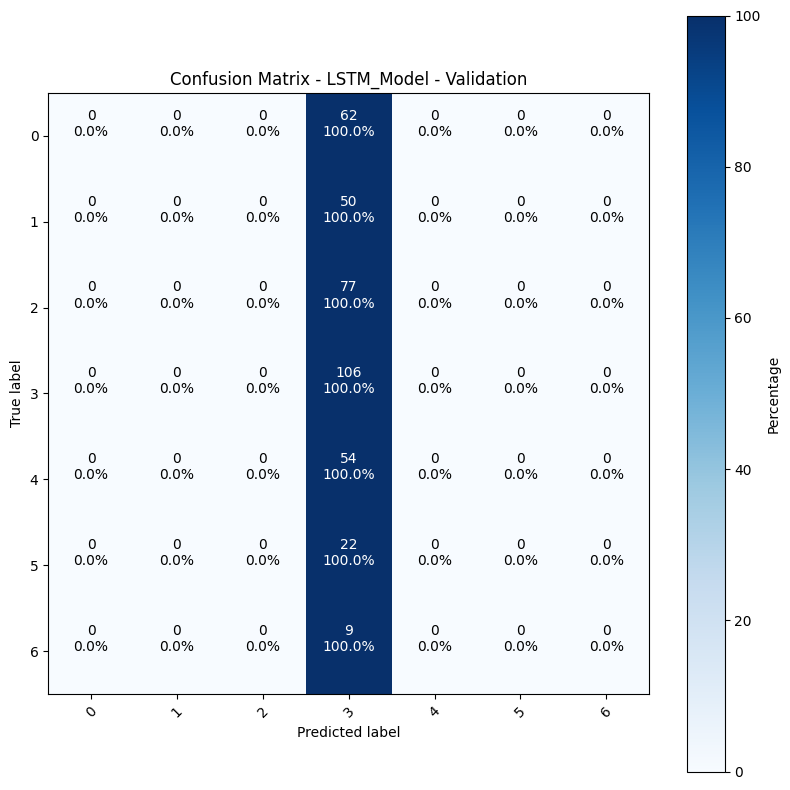

12/12 [==============================] - 0s 10ms/step
Test Accuracy: 0.28083989501312334
Test Precision: 0.07887104663098216
Test Recall: 0.28083989501312334
Test F1 Micro: 0.28083989501312334
Test F1 Macro: 0.0626463700234192


/data/home/raflizal.fikrar/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


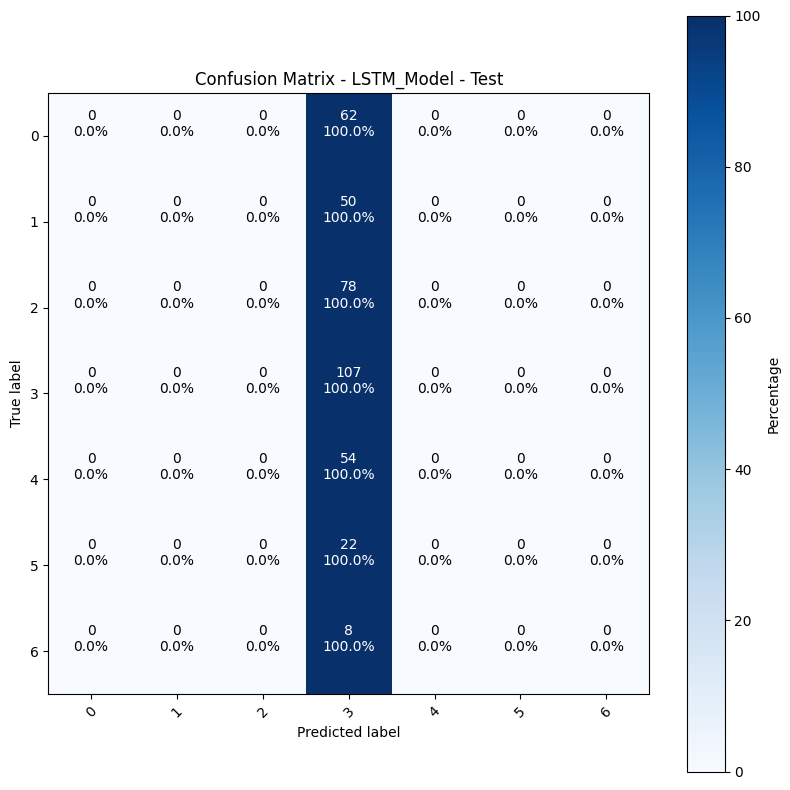

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD, RMSprop, Nadam, Adagrad
import tensorflow as tf

# Set the number of processors to be used via environment variables
os.environ['OMP_NUM_THREADS'] = '10'
os.environ['TF_NUM_INTRAOP_THREADS'] = '10'
os.environ['TF_NUM_INTEROP_THREADS'] = '10'

def create_lstm_model(units=50, dropout_rate=0.2, input_shape=(None, 31), num_classes=7, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Set optimizer based on the input parameter
    optimizer_instance = {
        'sgd': SGD(learning_rate=0.01),
        'rmsprop': RMSprop(learning_rate=0.001, rho=0.9),
        'nadam': Nadam(learning_rate=0.001),
        'adagrad': Adagrad(learning_rate=0.01),
        'adam': 'adam'  # Default optimizer
    }.get(optimizer, 'adam')
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer_instance, metrics=['accuracy'])
    return model

def prepare_data(df, sequence_length, feature_columns, target_column):
    # Convert to numeric and handle comma as decimal separator
    for col in feature_columns:
        df[col] = df[col].astype(str).str.replace(',', '.').astype(float)
    
    df[target_column] = df[target_column].astype(float)
    
    X, y = [], []
    for i in range(len(df) - sequence_length):
        X.append(df[feature_columns].iloc[i:i + sequence_length].values)
        y.append(df[target_column].iloc[i + sequence_length])
    X = np.array(X)
    y = np.array(y)
    
    # Reshape X to 3D array for LSTM input [samples, time steps, features]
    X = X.reshape((X.shape[0], sequence_length, len(feature_columns)))
    
    return X, y

def plot_confusion_matrix(cm, classes, title, dataset_name):
    plt.figure(figsize=(8, 8))
    percentages = (cm.T / cm.sum(axis=1) * 100).T
    plt.imshow(percentages, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=100)
    plt.title(f'Confusion Matrix - {title} - {dataset_name}')
    plt.colorbar(label='Percentage')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, f"{cm[i, j]}\n{percentages[i, j]:.1f}%", horizontalalignment='center',
                     color='white' if percentages[i, j] > 50 else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    plt.close()

def build_model(units, dropout_rate, input_shape, num_classes, optimizer):
    return create_lstm_model(units=units, dropout_rate=dropout_rate, input_shape=input_shape, num_classes=num_classes, optimizer=optimizer)

def modeling(Y, X, nama_model):
    # Adjust labels to start from 0
    Y = Y - 1  # Assuming labels start from 1 and need to be adjusted to start from 0

    # Stratified split
    X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
    X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42, stratify=Y_temp)

    # Ensure that X is float32 and Y is int
    X_train = X_train.astype(np.float32)
    X_val = X_val.astype(np.float32)
    X_test = X_test.astype(np.float32)
    Y_train = Y_train.astype(np.int)
    Y_val = Y_val.astype(np.int)
    Y_test = Y_test.astype(np.int)

    # One-hot encoding for labels
    num_classes = len(np.unique(Y))
    Y_train = to_categorical(Y_train, num_classes=num_classes)
    Y_test = to_categorical(Y_test, num_classes=num_classes)
    Y_val = to_categorical(Y_val, num_classes=num_classes)

    # Define the Keras model with different optimizers
    model = KerasClassifier(build_fn=build_model, input_shape=(X_train.shape[1], X_train.shape[2]), num_classes=num_classes, optimizer='sgd', verbose=0)

    # Grid search for hyperparameter tuning
    param_grid = {
        'units': [20, 50],  # Range of units to test
        'dropout_rate': [0.2, 0.5],  # Range of dropout rates to test
        'batch_size': [16, 32],  # Range of batch sizes to test
        'epochs': [10, 20],  # Range of epochs to test
        'optimizer': ['sgd', 'rmsprop', 'nadam', 'adagrad', 'adam']  # Different optimizers to test
    }

    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=2)  # Use fewer jobs and folds
    grid_result = grid.fit(X_train, Y_train)

    # Best model
    best_model = grid_result.best_estimator_
    print("Best parameters:", grid_result.best_params_)

    # Validation Evaluation
    Y_val_pred_prob = best_model.predict_proba(X_val)
    Y_val_pred = np.argmax(Y_val_pred_prob, axis=1)
    Y_true = np.argmax(Y_val, axis=1)

    accuracy_val_pred = accuracy_score(Y_true, Y_val_pred)
    precision_val_pred = precision_score(Y_true, Y_val_pred, average='weighted')
    recall_val_pred = recall_score(Y_true, Y_val_pred, average='weighted')
    f1_micro_val_pred = f1_score(Y_true, Y_val_pred, average='micro')
    f1_macro_val_pred = f1_score(Y_true, Y_val_pred, average='macro')
    cm = confusion_matrix(Y_true, Y_val_pred)

    print("Validation Accuracy:", accuracy_val_pred)
    print("Validation Precision:", precision_val_pred)
    print("Validation Recall:", recall_val_pred)
    print("Validation F1 Micro:", f1_micro_val_pred)
    print("Validation F1 Macro:", f1_macro_val_pred)
    
    plot_confusion_matrix(cm, classes=np.unique(Y_true), title=nama_model, dataset_name='Validation')

    # Test Evaluation
    Y_test_pred_prob = best_model.predict_proba(X_test)
    Y_test_pred = np.argmax(Y_test_pred_prob, axis=1)
    Y_true_test = np.argmax(Y_test, axis=1)

    accuracy_test_pred = accuracy_score(Y_true_test, Y_test_pred)
    precision_test_pred = precision_score(Y_true_test, Y_test_pred, average='weighted')
    recall_test_pred = recall_score(Y_true_test, Y_test_pred, average='weighted')
    f1_micro_test_pred = f1_score(Y_true_test, Y_test_pred, average='micro')
    f1_macro_test_pred = f1_score(Y_true_test, Y_test_pred, average='macro')
    cm_test = confusion_matrix(Y_true_test, Y_test_pred)

    print("Test Accuracy:", accuracy_test_pred)
    print("Test Precision:", precision_test_pred)
    print("Test Recall:", recall_test_pred)
    print("Test F1 Micro:", f1_micro_test_pred)
    print("Test F1 Macro:", f1_macro_test_pred)

    plot_confusion_matrix(cm_test, classes=np.unique(Y_true_test), title=nama_model, dataset_name='Test')

    # Save the evaluation results
    with open(f'evaluation_{nama_model}.txt', 'w') as f:
        f.write(f"Validation Accuracy: {accuracy_val_pred}\n")
        f.write(f"Validation Precision: {precision_val_pred}\n")
        f.write(f"Validation Recall: {recall_val_pred}\n")
        f.write(f"Validation F1 Micro: {f1_micro_val_pred}\n")
        f.write(f"Validation F1 Macro: {f1_macro_val_pred}\n")
        f.write(f"Test Accuracy: {accuracy_test_pred}\n")
        f.write(f"Test Precision: {precision_test_pred}\n")
        f.write(f"Test Recall: {recall_test_pred}\n")
        f.write(f"Test F1 Micro: {f1_micro_test_pred}\n")
        f.write(f"Test F1 Macro: {f1_macro_test_pred}\n")

    # Save the best model
    joblib.dump(best_model, f'best_model_{nama_model}.pkl')

    return best_model

def model_utilization(file_path, sequence_length, nama_model):
    try:
        df = pd.read_csv(file_path, sep=';')
    except pd.errors.ParserError as e:
        print(f"Error parsing the CSV file: {e}")
        return None

    # Clean data: remove rows with inconsistent columns
    df = df.dropna()  # Drop rows with any NaN values
    feature_columns = [f'VH_{i}' for i in range(0, 31)]
    target_column = 'observation'

    # Prepare data
    X, y = prepare_data(df, sequence_length, feature_columns, target_column)
    plot_class_distribution(y)

    # Modeling and evaluation
    best_model = modeling(y, X, nama_model)

    return best_model

def plot_class_distribution(y, title='Class Distribution'):
    plt.figure(figsize=(10, 6))
    sns.histplot(y, kde=False, bins=len(set(y)), color='skyblue', edgecolor='black')
    plt.title(title)
    plt.xlabel('Kelas')
    plt.ylabel('Frekuensi')
    plt.xticks(ticks=sorted(set(y)))
    plt.grid(True)
    plt.show()

# Run model_utilization if script is executed as the main program
if __name__ == "__main__":
    file_path = '../../00_Data_Input/sampel_to_explore.csv'  # Update path here
    sequence_length = 31
    nama_model = 'LSTM_Model'
    best_model = model_utilization(file_path, sequence_length, nama_model)


In [13]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from keras.optimizers import Adam, SGD
import tensorflow as tf
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from keras.wrappers.scikit_learn import KerasClassifier

# Set the number of processors to be used via environment variables
os.environ['OMP_NUM_THREADS'] = '10'
os.environ['TF_NUM_INTRAOP_THREADS'] = '10'
os.environ['TF_NUM_INTEROP_THREADS'] = '10'

from keras.optimizers import Adam, SGD, Adadelta, Adagrad

def create_lstm_model(units=64, dropout_rate=0.2, optimizer_name='adam', learning_rate=0.001, input_shape=(31, 30), num_classes=7):
    model = Sequential()
    model.add(Bidirectional(LSTM(units, return_sequences=True), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))

    # Select the optimizer based on the optimizer_name parameter
    if optimizer_name == 'adam':
        optimizer_instance = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'sgd':
        optimizer_instance = SGD(learning_rate=learning_rate)
    elif optimizer_name == 'adadelta':
        optimizer_instance = Adadelta(learning_rate=learning_rate)
    elif optimizer_name == 'adagrad':
        optimizer_instance = Adagrad(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

    model.compile(loss='categorical_crossentropy', optimizer=optimizer_instance, metrics=['accuracy'])
    return model

def optimize_lstm(X_train, Y_train, X_val, Y_val, num_classes):
    model = KerasClassifier(build_fn=create_lstm_model, input_shape=(X_train.shape[1], X_train.shape[2]), num_classes=num_classes, verbose=0)

    param_grid = {
        'units': [64, 128],
        'dropout_rate': [0.1, 0.2],
        'optimizer_name': ['adam', 'sgd', 'adadelta', 'adagrad'],
        'learning_rate': [1e-3, 1e-2],  # Including a wider range for learning rates
        'epochs': [80, 100],
        'batch_size': [10]
    }

    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=3, verbose=1)
    grid_result = grid.fit(X_train, Y_train, validation_data=(X_val, Y_val))

    print('Best parameters found:', grid_result.best_params_)
    print('Best cross-validation accuracy:', grid_result.best_score_)

    return grid_result.best_estimator_

def prepare_data(df, sequence_length, feature_columns, target_column):
    for col in feature_columns:
        df[col] = df[col].astype(str).str.replace(',', '.').astype(float)
    
    df[target_column] = df[target_column].astype(float)
    
    X, y = [], []
    for i in range(len(df) - sequence_length):
        X.append(df[feature_columns].iloc[i:i + sequence_length].values)
        y.append(df[target_column].iloc[i + sequence_length])
    X = np.array(X)
    y = np.array(y)
    
    scaler = StandardScaler()
    X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
    
    X = X.reshape((X.shape[0], sequence_length, len(feature_columns)))
    
    return X, y

def plot_confusion_matrix(cm, classes, title, dataset_name, output_dir):
    plt.figure(figsize=(8, 8))
    percentages = (cm.T / cm.sum(axis=1) * 100).T
    plt.imshow(percentages, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=100)
    plt.title(f'Confusion Matrix - {title} - {dataset_name}')
    plt.colorbar(label='Percentage')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, f"{cm[i, j]}\n{percentages[i, j]:.1f}%", horizontalalignment='center',
                     color='white' if percentages[i, j] > 50 else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, f'confusion_matrix_{dataset_name}.png'))
    plt.close()

def plot_loss(history, title, output_dir):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss - {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, f'loss_plot_{title}.png'))
    plt.close()

def plot_class_distribution(y, output_dir):
    plt.figure(figsize=(10, 6))
    sns.countplot(x=y)
    plt.title('Class Distribution')
    plt.xlabel('Classes')
    plt.ylabel('Frequency')
    
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, 'class_distribution.png'))
    plt.close()

def modeling(Y, X, nama_model, output_dir):
    Y = Y - 1
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(Y), y=Y)
    class_weights = dict(enumerate(class_weights))

    X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
    X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42, stratify=Y_temp)

    X_train = X_train.astype(np.float32)
    X_val = X_val.astype(np.float32)
    X_test = X_test.astype(np.float32)
    Y_train = Y_train.astype(np.int)
    Y_val = Y_val.astype(np.int)
    Y_test = Y_test.astype(np.int)

    num_classes = len(np.unique(Y))
    Y_train = to_categorical(Y_train, num_classes=num_classes)
    Y_test = to_categorical(Y_test, num_classes=num_classes)
    Y_val = to_categorical(Y_val, num_classes=num_classes)

    best_model = optimize_lstm(X_train, Y_train, X_val, Y_val, num_classes)

    history = best_model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=best_model.epochs, 
                             batch_size=best_model.batch_size, verbose=1, class_weight=class_weights)

    plot_loss(history, nama_model, output_dir)

    # Predictions for Validation Set
    Y_val_pred_prob = best_model.predict(X_val)
    Y_val_pred = np.argmax(Y_val_pred_prob, axis=1)
    Y_true_val = np.argmax(Y_val, axis=1)

    # Predictions for Test Set
    Y_test_pred_prob = best_model.predict(X_test)
    Y_test_pred = np.argmax(Y_test_pred_prob, axis=1)
    Y_true_test = np.argmax(Y_test, axis=1)

    # Compute Confusion Matrices
    cm_val = confusion_matrix(Y_true_val, Y_val_pred)
    cm_test = confusion_matrix(Y_true_test, Y_test_pred)

    # Plot and Save Confusion Matrices
    plot_confusion_matrix(cm_val, classes=np.unique(Y_true_val), title=nama_model, dataset_name='Validation', output_dir=output_dir)
    plot_confusion_matrix(cm_test, classes=np.unique(Y_true_test), title=nama_model, dataset_name='Test', output_dir=output_dir)

    accuracy_test_pred = accuracy_score(Y_true_test, Y_test_pred)
    precision_test_pred = precision_score(Y_true_test, Y_test_pred, average='weighted')
    recall_test_pred = recall_score(Y_true_test, Y_test_pred, average='weighted')
    f1_micro_test_pred = f1_score(Y_true_test, Y_test_pred, average='micro')
    f1_macro_test_pred = f1_score(Y_true_test, Y_test_pred, average='macro')

    print("Test Accuracy:", accuracy_test_pred)
    print("Test Precision:", precision_test_pred)
    print("Test Recall:", recall_test_pred)
    print("Test F1 Micro:", f1_micro_test_pred)
    print("Test F1 Macro:", f1_macro_test_pred)

    joblib.dump(best_model, os.path.join(output_dir, f'best_model_{nama_model}.pkl'))

    return best_model

def model_utilization(file_path, sequence_length, nama_model):
    output_dir = 'output'

    try:
        df = pd.read_csv(file_path, sep=';')
    except pd.errors.ParserError as e:
        print(f"Error parsing the CSV file: {e}")
        return None

    df = df.dropna()
    feature_columns = [f'VH_{i}' for i in range(0, 31)]
    target_column = 'observation'

    X, y = prepare_data(df, sequence_length, feature_columns, target_column)
    plot_class_distribution(y, output_dir)

    best_model = modeling(y, X, nama_model, output_dir)

    return best_model

if __name__ == "__main__":
    file_path = '../../00_Data_Input/sampel_to_explore.csv'
    sequence_length = 31
    nama_model = 'LSTM_Model'
    best_model = model_utilization(file_path, sequence_length, nama_model)
    

Fitting 3 folds for each of 64 candidates, totalling 192 fits


/tmp/ipykernel_1678119/252949824.py:147: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_train = Y_train.astype(np.int)
/tmp/ipykernel_1678119/252949824.py:148: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1

KeyboardInterrupt: 

### Optuna Framework Hyperparameter Tuning

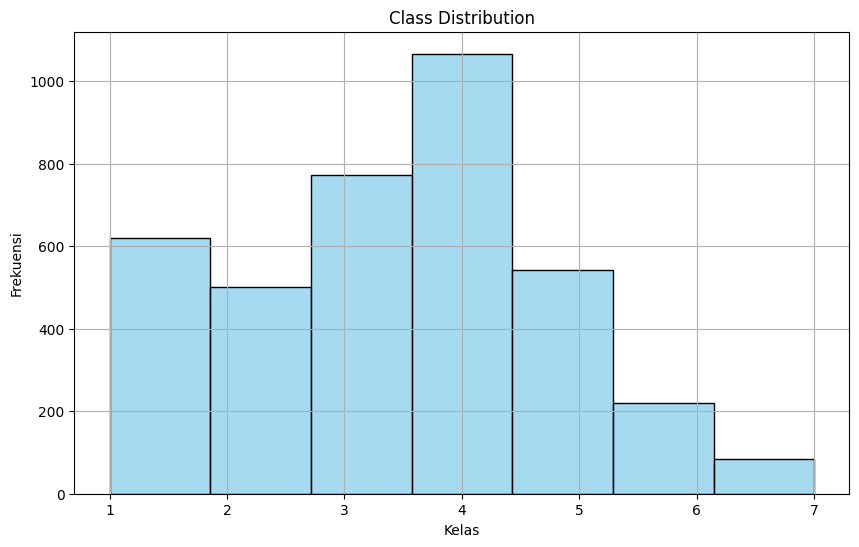

/tmp/ipykernel_1678119/2573284172.py:174: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_train = Y_train.astype(np.int)
/tmp/ipykernel_1678119/2573284172.py:175: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy

Best trial:
  Value: 0.2789473831653595
  Params: 
    units: 39
    dropout_rate: 0.11461464434763541
    optimizer: adam
    epochs: 69
    batch_size: 10


2024-08-20 15:12:39.450338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-20 15:12:39.452767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-20 15:12:39.454310: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/69


2024-08-20 15:12:39.699355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-20 15:12:39.701832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-20 15:12:39.703462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

305/305 [==============================] - ETA: 0s - loss: 1.7938 - accuracy: 0.2682

2024-08-20 15:12:57.351929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-20 15:12:57.354154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-20 15:12:57.355627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

305/305 [==============================] - 19s 39ms/step - loss: 1.7938 - accuracy: 0.2682 - val_loss: 1.7743 - val_accuracy: 0.2789
Epoch 2/69
305/305 [==============================] - 11s 36ms/step - loss: 1.7829 - accuracy: 0.2724 - val_loss: 1.7758 - val_accuracy: 0.2789
Epoch 3/69
305/305 [==============================] - 10s 34ms/step - loss: 1.7767 - accuracy: 0.2787 - val_loss: 1.7742 - val_accuracy: 0.2789
Epoch 4/69
305/305 [==============================] - 11s 36ms/step - loss: 1.7789 - accuracy: 0.2777 - val_loss: 1.7732 - val_accuracy: 0.2789
Epoch 5/69
305/305 [==============================] - 11s 35ms/step - loss: 1.7788 - accuracy: 0.2774 - val_loss: 1.7734 - val_accuracy: 0.2789
Epoch 6/69
305/305 [==============================] - 11s 35ms/step - loss: 1.7727 - accuracy: 0.2767 - val_loss: 1.7745 - val_accuracy: 0.2789
Epoch 7/69
305/305 [==============================] - 11s 36ms/step - loss: 1.7724 - accuracy: 0.2744 - val_loss: 1.7761 - val_accuracy: 0.2789
Epo

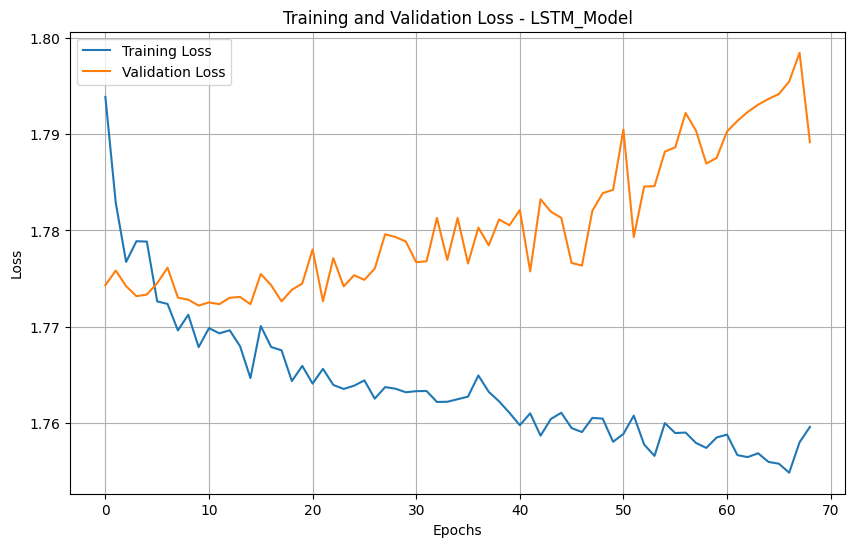

2024-08-20 15:24:53.308055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-20 15:24:53.310782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-20 15:24:53.312314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

12/12 [==============================] - 1s 14ms/step
Test Accuracy: 0.28346456692913385
Test Precision: 0.10028462800988926
Test Recall: 0.28346456692913385
Test F1 Micro: 0.28346456692913385
Test F1 Macro: 0.09465020576131687


/data/home/raflizal.fikrar/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


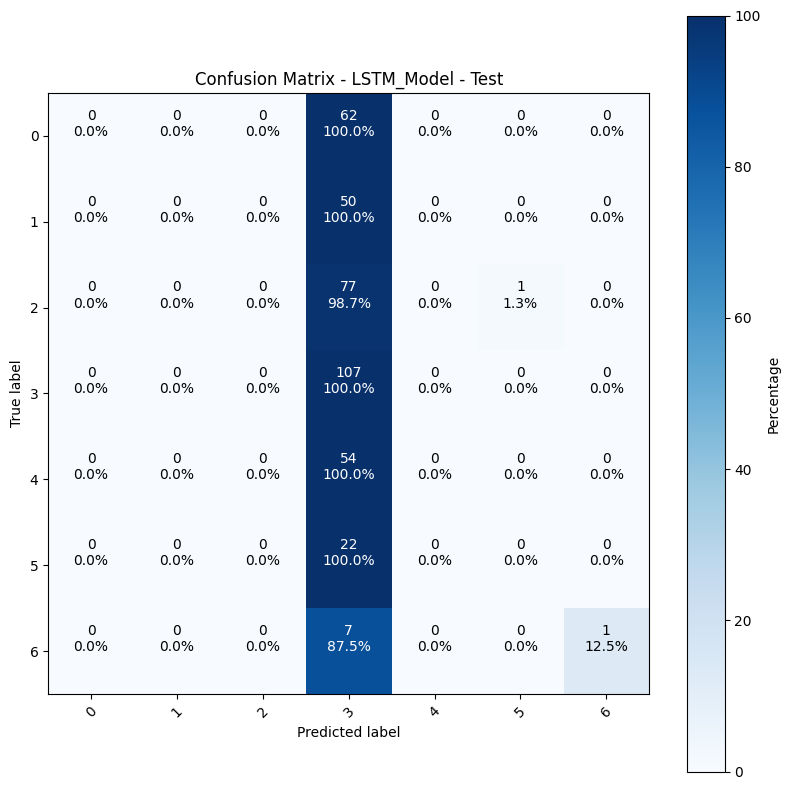

In [8]:
import optuna
from optuna.integration import TFKerasPruningCallback
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import SGD, RMSprop, Nadam, Adagrad
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf

def create_lstm_model(trial, input_shape, num_classes):
    units = trial.suggest_int('units', 32, 64)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.2)
    optimizer_name = trial.suggest_categorical('optimizer', ['sgd', 'adagrad', 'adam'])

    model = Sequential()
    model.add(LSTM(units, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))

    optimizer_instance = {
        'sgd': SGD(learning_rate=0.01),
        'adagrad': Adagrad(learning_rate=0.01),
        'adam': 'adam'  # Default optimizer
    }.get(optimizer_name, 'adam')

    model.compile(loss='categorical_crossentropy', optimizer=optimizer_instance, metrics=['accuracy'])
    return model

def progressive_lr_scheduler(epoch, lr):
    if epoch < 50:
        return lr
    else:
        return lr * tf.math.exp(-0.05)  # Mengurangi learning rate secara eksponensial

def objective(trial, X_train, Y_train, X_val, Y_val, num_classes):
    model = create_lstm_model(trial, input_shape=(X_train.shape[1], X_train.shape[2]), num_classes=num_classes)

    early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    pruning_callback = TFKerasPruningCallback(trial, monitor='val_accuracy')
    lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(progressive_lr_scheduler)

    epochs = trial.suggest_int('epochs', 50, 100)  # Sesuaikan epoch antara 50 dan 100

    history = model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        batch_size=trial.suggest_int('batch_size', 5, 10),
        epochs=epochs,
        callbacks=[early_stopping_callback, pruning_callback, lr_scheduler_callback],
        verbose=0
    )

    score = model.evaluate(X_val, Y_val, verbose=0)
    val_accuracy = score[1]

    return val_accuracy

def prepare_data(df, sequence_length, feature_columns, target_column):
    # Convert to numeric and handle comma as decimal separator
    for col in feature_columns:
        df[col] = df[col].astype(str).str.replace(',', '.').astype(float)
    
    df[target_column] = df[target_column].astype(float)
    
    X, y = [], []
    for i in range(len(df) - sequence_length):
        X.append(df[feature_columns].iloc[i:i + sequence_length].values)
        y.append(df[target_column].iloc[i + sequence_length])
    X = np.array(X)
    y = np.array(y)
    
    # Reshape X to 3D array for LSTM input [samples, time steps, features]
    X = X.reshape((X.shape[0], sequence_length, len(feature_columns)))
    
    return X, y

def plot_confusion_matrix(cm, classes, title, dataset_name):
    plt.figure(figsize=(8, 8))
    percentages = (cm.T / cm.sum(axis=1) * 100).T
    plt.imshow(percentages, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=100)
    plt.title(f'Confusion Matrix - {title} - {dataset_name}')
    plt.colorbar(label='Percentage')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, f"{cm[i, j]}\n{percentages[i, j]:.1f}%", horizontalalignment='center',
                     color='white' if percentages[i, j] > 50 else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    plt.close()

def plot_loss(history, title):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss - {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    # Simpan plot sebagai gambar
    plt.savefig(f'plot_loss_{title}.png')
    plt.show()
    plt.close()

def optimize_lstm(X_train, Y_train, X_val, Y_val, num_classes):
    study = optuna.create_study(direction='maximize')
    
    # Passing necessary variables to the objective function
    study.optimize(lambda trial: objective(trial, X_train, Y_train, X_val, Y_val, num_classes), n_trials=100, timeout=600)

    print('Best trial:')
    trial = study.best_trial
    print('  Value: {}'.format(trial.value))
    print('  Params: ')
    for key, value in trial.params.items():
        print('    {}: {}'.format(key, value))

    return trial

def modeling(Y, X, nama_model):
    # Adjust labels to start from 0
    Y = Y - 1  # Assuming labels start from 1 and need to be adjusted to start from 0

    # Stratified split
    X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
    X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42, stratify=Y_temp)

    # Ensure that X is float32 and Y is int
    X_train = X_train.astype(np.float32)
    X_val = X_val.astype(np.float32)
    X_test = X_test.astype(np.float32)
    Y_train = Y_train.astype(np.int)
    Y_val = Y_val.astype(np.int)
    Y_test = Y_test.astype(np.int)

    # One-hot encoding for labels
    num_classes = len(np.unique(Y))
    Y_train = to_categorical(Y_train, num_classes=num_classes)
    Y_test = to_categorical(Y_test, num_classes=num_classes)
    Y_val = to_categorical(Y_val, num_classes=num_classes)

    # Optimize LSTM model hyperparameters with Optuna
    best_trial = optimize_lstm(X_train, Y_train, X_val, Y_val, num_classes)

    # Rebuild the model with the best hyperparameters
    best_model = create_lstm_model(best_trial, input_shape=(X_train.shape[1], X_train.shape[2]), num_classes=num_classes)

    # Train the final model with the best parameters
    history = best_model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=best_trial.params['epochs'], batch_size=best_trial.params['batch_size'], verbose=1)

    # Plot and save loss
    plot_loss(history, nama_model)

    # Evaluate on the test set
    Y_test_pred_prob = best_model.predict(X_test)
    Y_test_pred = np.argmax(Y_test_pred_prob, axis=1)
    Y_true_test = np.argmax(Y_test, axis=1)

    accuracy_test_pred = accuracy_score(Y_true_test, Y_test_pred)
    precision_test_pred = precision_score(Y_true_test, Y_test_pred, average='weighted')
    recall_test_pred = recall_score(Y_true_test, Y_test_pred, average='weighted')
    f1_micro_test_pred = f1_score(Y_true_test, Y_test_pred, average='micro')
    f1_macro_test_pred = f1_score(Y_true_test, Y_test_pred, average='macro')
    cm_test = confusion_matrix(Y_true_test, Y_test_pred)

    print("Test Accuracy:", accuracy_test_pred)
    print("Test Precision:", precision_test_pred)
    print("Test Recall:", recall_test_pred)
    print("Test F1 Micro:", f1_micro_test_pred)
    print("Test F1 Macro:", f1_macro_test_pred)

    # Plot and save confusion matrix
    plot_confusion_matrix(cm_test, classes=np.unique(Y_true_test), title=nama_model, dataset_name='Test')

    # Save the best model
    joblib.dump(best_model, f'best_model_{nama_model}.pkl')

    return best_model

def model_utilization(file_path, sequence_length, nama_model):
    try:
        df = pd.read_csv(file_path, sep=';')
    except pd.errors.ParserError as e:
        print(f"Error parsing the CSV file: {e}")
        return None

    # Clean data: remove rows with inconsistent columns
    df = df.dropna()  # Drop rows with any NaN values
    feature_columns = [f'VH_{i}' for i in range(0, 31)]
    target_column = 'observation'

    # Prepare data
    X, y = prepare_data(df, sequence_length, feature_columns, target_column)
    plot_class_distribution(y)

    # Modeling and evaluation
    best_model = modeling(y, X, nama_model)

    return best_model

def plot_class_distribution(y, title='Class Distribution'):
    plt.figure(figsize=(10, 6))
    sns.histplot(y, kde=False, bins=len(set(y)), color='skyblue', edgecolor='black')
    plt.title(title)
    plt.xlabel('Kelas')
    plt.ylabel('Frekuensi')
    plt.xticks(ticks=sorted(set(y)))
    plt.grid(True)
    plt.show()

# Run model_utilization if script is executed as the main program
if __name__ == "__main__":
    file_path = '../../00_Data_Input/sampel_to_explore.csv'  # Update path here
    sequence_length = 31
    nama_model = 'LSTM_Model'
    best_model = model_utilization(file_path, sequence_length, nama_model)


In [20]:
import optuna
from optuna.integration import TFKerasPruningCallback
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from keras.optimizers import SGD, Adam, Adadelta
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split
import os

def create_lstm_model(trial, input_shape, num_classes):
    units = trial.suggest_int('units', 64, 128)
    dropout_rate = trial.suggest_float('dropout_rate', 0.05, 0.2)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'sgd', 'adadelta'])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3)

    model = Sequential()
    model.add(Bidirectional(LSTM(units, return_sequences=True)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))

    if optimizer_name == 'adam':
        optimizer_instance = Adam(learning_rate=learning_rate, clipnorm=1.0)
    elif optimizer_name == 'sgd':
        optimizer_instance = SGD(learning_rate=learning_rate)
    else:  # optimizer_name == 'adadelta'
        optimizer_instance = Adadelta(learning_rate=learning_rate)

    model.compile(loss='categorical_crossentropy', optimizer=optimizer_instance, metrics=['accuracy'])
    return model

def prepare_data(df, sequence_length, feature_columns, target_column):
    for col in feature_columns:
        df[col] = df[col].astype(str).str.replace(',', '.').astype(float)
    
    df[target_column] = df[target_column].astype(float)
    
    X, y = [], []
    for i in range(len(df) - sequence_length):
        X.append(df[feature_columns].iloc[i:i + sequence_length].values)
        y.append(df[target_column].iloc[i + sequence_length])
    X = np.array(X)
    y = np.array(y)
    
    # Feature scaling
    scaler = StandardScaler()
    X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
    
    X = X.reshape((X.shape[0], sequence_length, len(feature_columns)))
    
    return X, y

def plot_confusion_matrix(cm, classes, title, dataset_name, output_dir):
    plt.figure(figsize=(8, 8))
    percentages = (cm.T / cm.sum(axis=1) * 100).T
    plt.imshow(percentages, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=100)
    plt.title(f'Confusion Matrix - {title} - {dataset_name}')
    plt.colorbar(label='Percentage')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, f"{cm[i, j]}\n{percentages[i, j]:.1f}%", horizontalalignment='center',
                     color='white' if percentages[i, j] > 50 else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    # Save plot
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, f'confusion_matrix_{dataset_name}.png'))
    plt.close()

def plot_loss(history, title, output_dir):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss - {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Save plot
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, f'loss_plot_{title}.png'))
    plt.close()

def plot_class_distribution(y, output_dir):
    plt.figure(figsize=(10, 6))
    sns.countplot(x=y)
    plt.title('Class Distribution')
    plt.xlabel('Classes')
    plt.ylabel('Frequency')
    
    # Save plot
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, 'class_distribution.png'))
    plt.close()

def objective(trial, X_train, Y_train, X_val, Y_val, num_classes):
    model = create_lstm_model(trial, input_shape=(X_train.shape[1], X_train.shape[2]), num_classes=num_classes)

    early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    pruning_callback = TFKerasPruningCallback(trial, monitor='val_accuracy')
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

    epochs = trial.suggest_int('epochs', 80, 100)

    history = model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        batch_size=trial.suggest_int('batch_size', 10, 10),
        epochs=epochs,
        callbacks=[early_stopping_callback, pruning_callback, reduce_lr],
        verbose=0
    )

    score = model.evaluate(X_val, Y_val, verbose=0)
    val_accuracy = score[1]

    return val_accuracy

def optimize_lstm(X_train, Y_train, X_val, Y_val, num_classes):
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, X_train, Y_train, X_val, Y_val, num_classes), n_trials=100, timeout=600)

    print('Best trial:')
    trial = study.best_trial
    print('  Value: {}'.format(trial.value))
    print('  Params: ')
    for key, value in trial.params.items():
        print('    {}: {}'.format(key, value))

    # Create and evaluate the best model
    best_model = create_lstm_model(trial, input_shape=(X_train.shape[1], X_train.shape[2]), num_classes=num_classes)
    best_model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=trial.params['epochs'], 
                   batch_size=trial.params['batch_size'], verbose=1)

    Y_val_pred_prob = best_model.predict(X_val)
    Y_val_pred = np.argmax(Y_val_pred_prob, axis=1)
    Y_true_val = np.argmax(Y_val, axis=1)
    
    # Compute confusion matrix
    cm_val = confusion_matrix(Y_true_val, Y_val_pred)
    
    # Plot confusion matrix for validation
    plot_confusion_matrix(cm_val, classes=np.unique(Y_true_val), title='Validation Confusion Matrix - Best Trial', dataset_name='Validation', output_dir='output')

    return trial

def modeling(Y, X, nama_model, output_dir):
    Y = Y - 1

    # Compute class weights
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(Y), y=Y)
    class_weights = dict(enumerate(class_weights))

    X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
    X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42, stratify=Y_temp)

    X_train = X_train.astype(np.float32)
    X_val = X_val.astype(np.float32)
    X_test = X_test.astype(np.float32)
    Y_train = Y_train.astype(np.int)
    Y_val = Y_val.astype(np.int)
    Y_test = Y_test.astype(np.int)

    num_classes = len(np.unique(Y))
    Y_train = to_categorical(Y_train, num_classes=num_classes)
    Y_test = to_categorical(Y_test, num_classes=num_classes)
    Y_val = to_categorical(Y_val, num_classes=num_classes)

    best_trial = optimize_lstm(X_train, Y_train, X_val, Y_val, num_classes)

    best_model = create_lstm_model(best_trial, input_shape=(X_train.shape[1], X_train.shape[2]), num_classes=num_classes)

    history = best_model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=best_trial.params['epochs'], 
                             batch_size=best_trial.params['batch_size'], verbose=1, class_weight=class_weights)

    plot_loss(history, nama_model, output_dir)

    Y_test_pred_prob = best_model.predict(X_test)
    Y_test_pred = np.argmax(Y_test_pred_prob, axis=1)
    Y_true_test = np.argmax(Y_test, axis=1)

    accuracy_test_pred = accuracy_score(Y_true_test, Y_test_pred)
    precision_test_pred = precision_score(Y_true_test, Y_test_pred, average='weighted')
    recall_test_pred = recall_score(Y_true_test, Y_test_pred, average='weighted')
    f1_micro_test_pred = f1_score(Y_true_test, Y_test_pred, average='micro')
    f1_macro_test_pred = f1_score(Y_true_test, Y_test_pred, average='macro')
    cm_test = confusion_matrix(Y_true_test, Y_test_pred)

    print("Test Accuracy:", accuracy_test_pred)
    print("Test Precision:", precision_test_pred)
    print("Test Recall:", recall_test_pred)
    print("Test F1 Micro:", f1_micro_test_pred)
    print("Test F1 Macro:", f1_macro_test_pred)

    plot_confusion_matrix(cm_test, classes=np.unique(Y_true_test), title=nama_model, dataset_name='Test', output_dir=output_dir)

    joblib.dump(best_model, os.path.join(output_dir, f'best_model_{nama_model}.pkl'))

    return best_model

def model_utilization(file_path, sequence_length, nama_model):
    output_dir = 'output'

    try:
        df = pd.read_csv(file_path, sep=';')
    except pd.errors.ParserError as e:
        print(f"Error parsing the CSV file: {e}")
        return None

    df = df.dropna()
    feature_columns = [f'VH_{i}' for i in range(0, 31)]
    target_column = 'observation'

    X, y = prepare_data(df, sequence_length, feature_columns, target_column)
    plot_class_distribution(y, output_dir)

    best_model = modeling(y, X, nama_model, output_dir)

    return best_model

# Run model_utilization if script is executed as the main program
if __name__ == "__main__":
    file_path = '../../00_Data_Input/sampel_to_explore.csv'  # Update path here
    sequence_length = 31
    nama_model = 'LSTM_Model'
    best_model = model_utilization(file_path, sequence_length, nama_model)


/tmp/ipykernel_1678119/2063381958.py:178: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_train = Y_train.astype(np.int)
/tmp/ipykernel_1678119/2063381958.py:179: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy

Best trial:
  Value: 0.27368420362472534
  Params: 
    units: 71
    dropout_rate: 0.12738767257528344
    optimizer: sgd
    learning_rate: 0.0009026316793106807
    epochs: 98
    batch_size: 10
Epoch 1/98


2024-08-21 08:38:25.153594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-21 08:38:25.156252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-21 08:38:25.157815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

305/305 [==============================] - ETA: 0s - loss: 2.3347 - accuracy: 0.1574

2024-08-21 08:38:42.708773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-21 08:38:42.710633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-21 08:38:42.712513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

305/305 [==============================] - 19s 40ms/step - loss: 2.3347 - accuracy: 0.1574 - val_loss: 1.9237 - val_accuracy: 0.2000
Epoch 2/98
305/305 [==============================] - 11s 37ms/step - loss: 2.1406 - accuracy: 0.1880 - val_loss: 1.9887 - val_accuracy: 0.1947
Epoch 3/98
305/305 [==============================] - 11s 37ms/step - loss: 2.0318 - accuracy: 0.1978 - val_loss: 1.9613 - val_accuracy: 0.2342
Epoch 4/98
305/305 [==============================] - 11s 37ms/step - loss: 1.9759 - accuracy: 0.2172 - val_loss: 1.9251 - val_accuracy: 0.2526
Epoch 5/98
305/305 [==============================] - 11s 37ms/step - loss: 1.9507 - accuracy: 0.2291 - val_loss: 1.9116 - val_accuracy: 0.2553
Epoch 6/98
305/305 [==============================] - 12s 38ms/step - loss: 1.9033 - accuracy: 0.2429 - val_loss: 1.8690 - val_accuracy: 0.2500
Epoch 7/98
305/305 [==============================] - 12s 38ms/step - loss: 1.8865 - accuracy: 0.2461 - val_loss: 1.8530 - val_accuracy: 0.2447
Epo

2024-08-21 08:57:17.333295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-21 08:57:17.335944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-21 08:57:17.337633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

12/12 [==============================] - 1s 17ms/step
Epoch 1/98


2024-08-21 08:57:19.295994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-21 08:57:19.298567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-21 08:57:19.300267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

305/305 [==============================] - ETA: 0s - loss: 2.1420 - accuracy: 0.1600

2024-08-21 08:57:39.723329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-21 08:57:39.725989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-21 08:57:39.727644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

305/305 [==============================] - 22s 41ms/step - loss: 2.1420 - accuracy: 0.1600 - val_loss: 1.9989 - val_accuracy: 0.1579
Epoch 2/98
305/305 [==============================] - 11s 37ms/step - loss: 1.9483 - accuracy: 0.1752 - val_loss: 2.1028 - val_accuracy: 0.1526
Epoch 3/98
305/305 [==============================] - 12s 38ms/step - loss: 1.8645 - accuracy: 0.1906 - val_loss: 2.0963 - val_accuracy: 0.1526
Epoch 4/98
305/305 [==============================] - 11s 37ms/step - loss: 1.8354 - accuracy: 0.2041 - val_loss: 2.1610 - val_accuracy: 0.1342
Epoch 5/98
305/305 [==============================] - 11s 37ms/step - loss: 1.7680 - accuracy: 0.2192 - val_loss: 2.0472 - val_accuracy: 0.1579
Epoch 6/98
305/305 [==============================] - 11s 37ms/step - loss: 1.7837 - accuracy: 0.2044 - val_loss: 2.0262 - val_accuracy: 0.1711
Epoch 7/98
305/305 [==============================] - 11s 36ms/step - loss: 1.7369 - accuracy: 0.2248 - val_loss: 2.0232 - val_accuracy: 0.1605
Epo

2024-08-21 09:15:57.570685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-21 09:15:57.573237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-21 09:15:57.574846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

12/12 [==============================] - 1s 18ms/step
Test Accuracy: 0.2099737532808399
Test Precision: 0.21612428834093853
Test Recall: 0.2099737532808399
Test F1 Micro: 0.2099737532808399
Test F1 Macro: 0.29110080283926526
